<a href="https://colab.research.google.com/github/amalvarezme/AnaliticaDatos/blob/master/Regresion_covidCSV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install wget
import wget
import pandas as pd
#datos covid19 - mundo
url = "https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_confirmed_global.csv&filename=time_series_covid19_confirmed_global.csv"
#datos Colombia
#url = "https://www.datos.gov.co/api/views/gt2j-8ykr/rows.csv?accessType=DOWNLOAD"
wget.download(url, 'covid.csv')
Xd = pd.read_csv('covid.csv')
Xd

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20
0,NaN,Afghanistan,33.000000,65.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,7,11,16,21,22,22,22,24,24,40,40,74,84,94,110,110,120,170,174,237,273,281,299,349,367,423,444,484,521,555,607,665,714,784,840,906,933,996,1026,1092
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,33,38,42,51,55,59,64,70,76,89,104,123,146,174,186,197,212,223,243,259,277,304,333,361,377,383,400,409,416,433,446,467,475,494,518,539,548,562,584,609
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,26,37,48,54,60,74,87,90,139,201,230,264,302,367,409,454,511,584,716,847,986,1171,1251,1320,1423,1468,1572,1666,1761,1825,1914,1983,2070,2160,2268,2418,2534,2629,2718,2811
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,2,39,39,53,75,88,113,133,164,188,224,267,308,334,370,376,390,428,439,466,501,525,545,564,583,601,601,638,646,659,673,673,696,704,713,717,717
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,2,2,3,3,3,4,4,5,7,7,7,8,8,8,10,14,16,17,19,19,19,19,19,19,19,19,19,19,24,24,24,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,Saint Pierre and Miquelon,France,46.885200,-56.315900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
260,NaN,South Sudan,6.877000,31.307000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2,2,3,4,4,4,4,4,4,4,4,4,4,4,4
261,NaN,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4,4,4,4,4,4,6,6,6,6,6,6,6,6,6,6
262,NaN,Sao Tome and Principe,0.186360,6.613081,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4


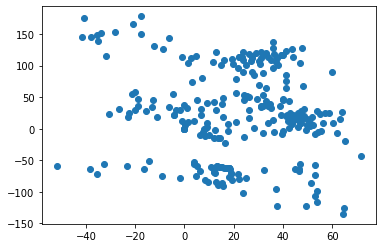

In [6]:
import numpy as np
import matplotlib.pyplot as plt
plt.scatter(Xd['Lat'],Xd['Long'])

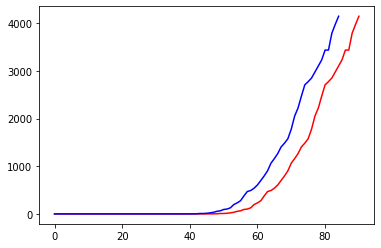

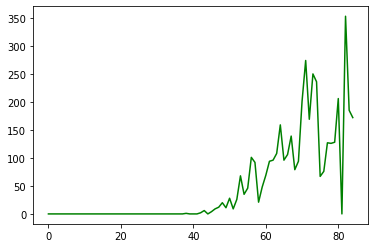

In [12]:
import numpy as np
import matplotlib.pyplot as plt

#funcion ventaneo
def covid_win(serie,w=5):
    pi =0
    pf = w
    X = serie[pi:pf].reshape(1,-1)
    y = serie[pf+1].reshape(1,-1)
    pi += 1
    pf+= 1
    while pf+1 < serie.shape[0]:
      X = np.append(X,serie[pi:pf].reshape(1,-1),axis=0)
      y = np.append(y,serie[pf+1].reshape(1,-1),axis=0)
      pi += 1
      pf+=1
    return X, y # X \in Real^{N x P = w}, y \in Real^N


ii = Xd[Xd.columns[1]] == 'Colombia'
#print(np.where(ii)[0][0])
#contagios  acumulados
serie = np.array(Xd.iloc[np.where(ii)[0][0],4:])
#numero contagiados por dia
serie_d = np.append(0,np.diff(serie))
#serie_d = np.append(0,np.cumsum(np.diff(serie)))
X,y = covid_win(serie,w=5)
X_d,y_d = covid_win(serie_d,w=5)

plt.plot(serie,'r')
plt.plot(y,'b')
plt.show()
plt.plot(y_d,'g')



# Entrenamiento de regresor para covid 19 - Colombia
# Análisis exploratorio - visualización en 2D PCA
# Validación cruzada y anidada (pocos datos)

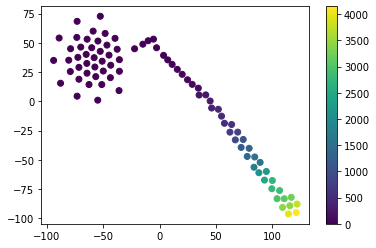

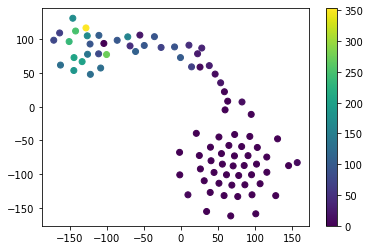

In [22]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

red = TSNE(n_components = 2,perplexity=10)
red_d = TSNE(n_components = 2,perplexity=10)

z = red.fit_transform(X)
z_d = red.fit_transform(X_d)

plt.scatter(z[:,0],z[:,1],c=y)
plt.colorbar()
plt.show()


plt.scatter(z_d[:,0],z_d[:,1],c=y_d)
plt.colorbar()
plt.show()


$$w^* = (X^\top X + \lambda I)^{-1}X^\top y $$

$$y_n = x_n w^*$$

In [28]:
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score, cross_val_predict
#pocos datos y mucha incertidumbre, validación cruzada anidada

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
print(X_train.shape)
print(X_test.shape)

(59, 5)
(26, 5)


In [0]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score
from joblib import dump, load
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error as mse

steps = [('scaler', StandardScaler()), #estandarizar cada atriuto columna de xtrain centrada en 0 y var = 1
         #('rep', PCA(n_components=0.9),
          ('reg',  KernelRidge(kernel = 'rbf'))] #clasificador 
                 


#parametros a buscar por busqueda por grilla
parameters ={'reg__gamma':[1e-3,1e-2,1e-1,1,10,100],
             'reg__alpha':[1e-3,1e-2,1e-1,1,10,100]
             }

In [32]:
#valildacion cruzada anidada
Niter = 10 #numero particiones
msev =np.zeros(Niter)#arreglo para guardar acierto
best_estimators = []#mejor metodo por iteracion
best_parameters = []#mejor metodo por iteracion


#for r in range(len(steps)):
for j in range(Niter): #outter loop
        print('it %d/%d'%(j+1,Niter))
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
        #method = Pipeline(steps[r])          

        grid_search = GridSearchCV(method, parameters,cv=5,verbose=10,scoring='neg_mean_squared_error',n_jobs=5) #cv inner loop
        #generar mejor modelo
        grid_search.fit(X_train,y_train)
        #estimar salida conjunto de test
        y_pred = grid_search.best_estimator_.predict(X_test)
        #guardar mejor modelo
        best_estimators.append(grid_search.best_estimator_)
        best_parameters.append(grid_search.best_params_)
        
        #guardar acierto
        msev[j] = mse(y_test,y_pred)
        print('it %d/%d'%(j+1,Niter))
        print(grid_search.best_params_)
        print('mse:',msev[j])
        
        savedata = {
            'acc':msev,
            'best_models':best_estimators,
            'best_parameters':best_parameters,
              } 
        dump(savedata,'covid19_1.joblib')

it 1/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1871s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0400s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  45 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0626s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  79 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0891s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 152 out of 180 | elapsed:    2.6s remaining:    0.5s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    2.6s finished
[Parallel(n_jobs=5)

it 1/10
{'reg__alpha': 0.001, 'reg__gamma': 0.1}
mse: 958.0937078048172
it 2/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0909s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 154 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0070s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0070s.) Setting batch_size=4.


it 2/10
{'reg__alpha': 0.001, 'reg__gamma': 0.1}
mse: 4261.305830760633
it 3/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0591s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  27 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1164s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 114 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0072s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0072s.) Setting batch_size=4.


it 3/10
{'reg__alpha': 0.001, 'reg__gamma': 0.001}
mse: 10440.944508175522
it 4/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0655s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done 114 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0072s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0072s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s


it 4/10
{'reg__alpha': 0.001, 'reg__gamma': 0.001}
mse: 4646.256794432858
it 5/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0847s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1422s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  74 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 141 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 163 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0057s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0718s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks  

it 5/10
{'reg__alpha': 0.001, 'reg__gamma': 0.1}
mse: 378.11239205905747
it 6/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0845s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0436s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 161 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0105s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0699s.) Setting batch_size=4.


it 6/10
{'reg__alpha': 0.001, 'reg__gamma': 0.001}
mse: 3883.496844486984
it 7/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0439s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1470s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 129 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 154 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0116s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0462s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s


it 7/10
{'reg__alpha': 0.001, 'reg__gamma': 0.1}
mse: 1454.8711247571928
it 8/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0706s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1045s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 129 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 161 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0163s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0448s.) Setting batch_size=4.


it 8/10
{'reg__alpha': 0.001, 'reg__gamma': 0.1}
mse: 4337.556851734953
it 9/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0590s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0928s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 161 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0065s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0065s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s


it 9/10
{'reg__alpha': 0.001, 'reg__gamma': 0.1}
mse: 3203.1381878858992
it 10/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0773s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1127s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  74 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 134 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 163 tasks      | elapsed:    0.6s


it 10/10
{'reg__alpha': 0.001, 'reg__gamma': 0.1}
mse: 2719.5127235296836


[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.6s finished


Por Niter de outter loop tengo valores de los hyperparameters

$$\gamma = [0.01,0.1,10,1000,10000,0.01]$$

$$\gamma = [0.01,0.01,0.01,0.1,1,0.01]$$

$$\gamma^* = moda/mediana(\gamma_i) = 0.01$$

Toma todos los datos los N = 85, entreno sobre todo el conjunto con los parametros encontrados utilizando validación cruzada anidad

$$\theta^*/w^* =f(X|\gamma^*)$$

$$ y_{new} = f(x_{new}|\gamma^*,\theta^*/w^*)$$